# Earth Tunnel Effect
9-second transition through the Earth, emerging into blue sky

In [1]:
# Install required packages if needed
# !pip install moviepy numpy --break-system-packages

In [2]:
from moviepy.editor import VideoClip, ColorClip, CompositeVideoClip
import numpy as np
from scipy.ndimage import gaussian_filter

In [3]:
# Video parameters
WIDTH, HEIGHT = 1400, 1000
DURATION = 9  # seconds
FPS = 60  # Smooth frame rate

# Timing breakdown:
# 0-6s: Dark tunnel with earth-toned particles moving outward
# 6-8s: Gradual brightening, blue appearing
# 8-9s: Emerging into bright blue sky

In [10]:
def make_tunnel_frame(t):
    """
    Generate a single frame of the tunnel effect
    t: time in seconds (0 to 9)
    """
    # Create base frame
    frame = np.zeros((HEIGHT, WIDTH, 3), dtype=np.float32)
    
    center_x, center_y = WIDTH // 2, HEIGHT // 2
    
    # Timeline:
    # 0-7s: Tunnel with streaking particles
    # 7-7.5s: Sudden transition to clean blue sky
    # 7.5-9s: Blue fades to black (space)
    
    if t < 7:
        # TUNNEL PHASE
        # Dark background
        base_brightness = 6 + (t / 7) * 10  # Darker overall
        bg_color = np.array([base_brightness * 0.5, base_brightness * 0.3, base_brightness * 0.2])
        frame[:, :] = bg_color
        
        # Pre-generate random properties for consistent but irregular streams
        np.random.seed(42)
        num_streams = 50  # Balanced number for good coverage and speed
        
        # Pre-compute all random variations
        angle_variations = (np.random.random(num_streams) - 0.5) * 0.4
        width_multipliers = 0.8 + np.random.random(num_streams) * 1.4
        speed_variations = 0.8 + np.random.random(num_streams) * 0.4
        
        # Earth tone colors - dimmer for inside the Earth
        color_choices = np.array([
            [120, 65, 35],    # Dim orange
            [100, 55, 20],    # Dark brown
            [140, 80, 40],    # Muted light orange
            [90, 45, 25],     # Very dark brown
            [130, 75, 40],    # Dim mid orange
            [110, 60, 30],    # Another dim brown
            [150, 90, 50],    # Slightly lighter orange
            [85, 45, 20]      # Very dark brown
        ], dtype=np.float32)
        
        for stream_idx in range(num_streams):
            # Irregular angular positions
            base_angle = (stream_idx / num_streams) * 2 * np.pi
            angle = base_angle + angle_variations[stream_idx]
            
            cos_angle = np.cos(angle)
            sin_angle = np.sin(angle)
            
            width_mult = width_multipliers[stream_idx]
            speed_var = speed_variations[stream_idx]
            
            # Fewer particles per stream but longer streaks
            for particle_offset in range(3):
                # Radial distance - particles move outward with time
                base_distance = (t * 180 * speed_var + particle_offset * 300) % 1500
                
                # Skip if particle is out of frame
                if base_distance > max(WIDTH, HEIGHT) * 0.85:
                    continue
                
                # Select color
                base_color = color_choices[(stream_idx + particle_offset) % len(color_choices)]
                
                # Much longer streaks - extended without performance hit
                streak_length = int(200 + base_distance / 4)  # Even longer streaks!
                
                # Wider base width
                base_width = max(6, int(35 - base_distance / 50))
                particle_width = int(base_width * width_mult)
                
                # Pre-calculate streak positions for vectorization
                streak_steps = np.arange(0, streak_length, 4)  # Skip every 4th for longer streaks without slowdown
                streak_dists = base_distance - streak_steps * 1.5
                
                # Filter valid distances
                valid_mask = streak_dists >= 0
                streak_dists = streak_dists[valid_mask]
                streak_steps = streak_steps[valid_mask]
                
                if len(streak_dists) == 0:
                    continue
                
                # Calculate all positions at once
                xs = (center_x + streak_dists * cos_angle).astype(int)
                ys = (center_y + streak_dists * sin_angle).astype(int)
                
                # Calculate fades - much stronger fade at tips, never fully bright
                fades = (1.0 - (streak_steps / streak_length) ** 0.5) * 0.6  # Max 60% brightness
                
                # Draw each point in the streak
                for i, (x, y, fade) in enumerate(zip(xs, ys, fades)):
                    color = base_color * fade
                    thickness = max(3, int(particle_width * fade * 0.8))
                    
                    # Draw a filled circle more efficiently
                    y_min = max(0, y - thickness)
                    y_max = min(HEIGHT, y + thickness + 1)
                    x_min = max(0, x - thickness)
                    x_max = min(WIDTH, x + thickness + 1)
                    
                    if y_max > y_min and x_max > x_min:
                        # Create a small grid for this blob
                        yy, xx = np.ogrid[y_min:y_max, x_min:x_max]
                        dist_grid = np.sqrt((xx - x)**2 + (yy - y)**2)
                        
                        # Irregular shape
                        irregularity = 0.7 + 0.3 * np.sin(stream_idx * 2.3 + particle_offset * 1.7)
                        mask = dist_grid < thickness * irregularity
                        
                        if np.any(mask):
                            blend = 0.6 * (1 - dist_grid / (thickness + 1)) * fade  # Reduced blend intensity
                            blend = np.clip(blend, 0, 1)
                            
                            # Apply to frame with additive blending
                            for c in range(3):
                                frame[y_min:y_max, x_min:x_max, c] = np.minimum(
                                    255,
                                    frame[y_min:y_max, x_min:x_max, c] + color[c] * blend * mask
                                )
        
        # Darken the center slightly (tunnel depth effect)
        y_coords, x_coords = np.ogrid[:HEIGHT, :WIDTH]
        center_dist = np.sqrt((x_coords - center_x)**2 + (y_coords - center_y)**2)
        max_dist = np.sqrt(center_x**2 + center_y**2)
        vignette = 0.5 + 0.5 * (center_dist / max_dist)
        frame = frame * vignette[:, :, np.newaxis]
    
    elif t < 7.5:
        # SUDDEN TRANSITION TO SKY (0.5 seconds)
        # Clean bright blue sky, no streaks
        transition_progress = (t - 7) / 0.5
        
        # Start with a bright flash, then settle to sky blue
        if transition_progress < 0.2:
            # Brief bright flash
            flash_intensity = 1.0 - (transition_progress / 0.2)
            sky_blue = np.array([135, 206, 235])
            white_flash = np.array([255, 255, 255])
            bg_color = sky_blue + (white_flash - sky_blue) * flash_intensity
        else:
            # Settle into sky blue
            bg_color = np.array([135, 206, 235])
        
        frame[:, :] = bg_color
    
    else:
        # FADE TO SPACE (7.5-9s = 1.5 seconds)
        fade_progress = (t - 7.5) / 1.5
        
        # Fade from sky blue to black
        start_color = np.array([135, 206, 235])  # Sky blue
        end_color = np.array([0, 0, 0])  # Space black
        bg_color = start_color + (end_color - start_color) * fade_progress
        
        frame[:, :] = bg_color
    
    # Clip values and convert to uint8
    frame = np.clip(frame, 0, 255).astype(np.uint8)
    
    return frame

In [11]:
# Create the video clip
print("Creating tunnel effect clip...")
tunnel_clip = VideoClip(make_tunnel_frame, duration=DURATION)
tunnel_clip = tunnel_clip.set_fps(FPS)

Creating tunnel effect clip...


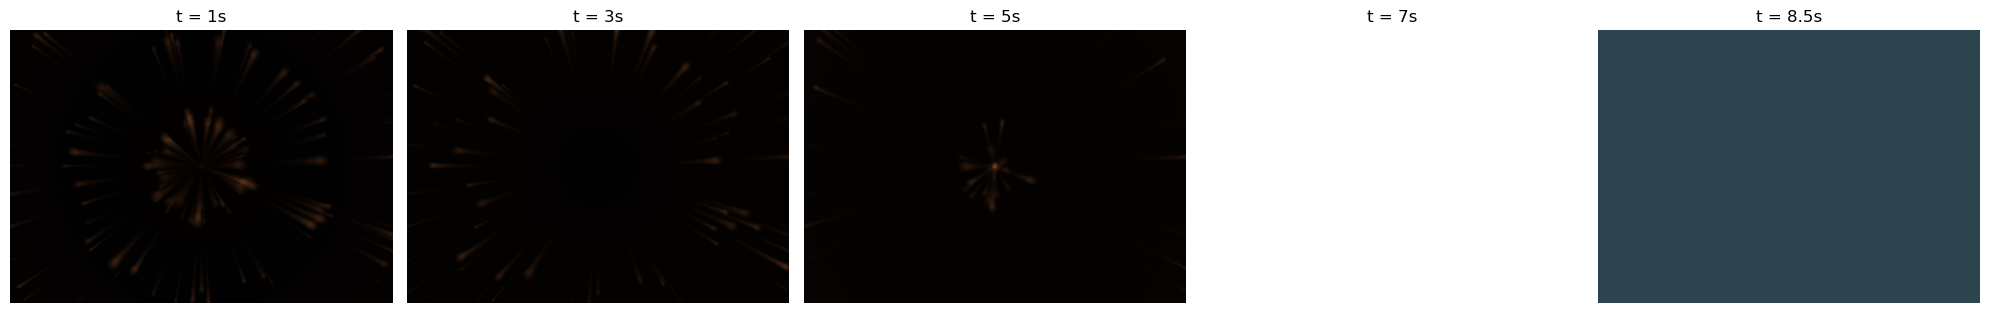

In [12]:
# Preview a single frame (middle of the tunnel)
import matplotlib.pyplot as plt

test_times = [1, 3, 5, 7, 8.5]
fig, axes = plt.subplots(1, 5, figsize=(20, 4))

for i, t in enumerate(test_times):
    frame = make_tunnel_frame(t)
    axes[i].imshow(frame)
    axes[i].set_title(f't = {t}s')
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [13]:
# Render the final video
output_file = "/Users/bmapes/Box/Sky_Symphony_Box/earth_tunnel_transition.mp4"
print(f"Rendering {DURATION}s video at {FPS} fps...")
print("This may take a few minutes...")

tunnel_clip.write_videofile(
    output_file,
    fps=FPS,
    codec='libx264',
    audio=False,
    preset='medium',
    bitrate='8000k'
)

print(f"\nDone! Video saved as: {output_file}")

Rendering 9s video at 60 fps...
This may take a few minutes...
Moviepy - Building video /Users/bmapes/Box/Sky_Symphony_Box/earth_tunnel_transition.mp4.
Moviepy - Writing video /Users/bmapes/Box/Sky_Symphony_Box/earth_tunnel_transition.mp4



Moviepy - Done !
Moviepy - video ready /Users/bmapes/Box/Sky_Symphony_Box/earth_tunnel_transition.mp4

Done! Video saved as: /Users/bmapes/Box/Sky_Symphony_Box/earth_tunnel_transition.mp4


In [22]:
# Black out the box with the date in it, and make 1s keyframes at high quality 

# Set input and output paths
input_path = "/Users/bmapes/Box/Sky_Symphony_Box/Oct2014BigSpot_171A.HD1080.mov"
output_path = "/Users/bmapes/Box/Sky_Symphony_Box/Oct2014BigSpot_171A.HD1080.nolabel.mp4"

# FFmpeg command with quality (CRF 18) and keyframes every 1 second (g=30 for 30fps)
!ffmpeg -i {input_path} \
  -vf "drawbox=x=0:y=ih-100:w=650:h=100:color=black:t=fill" \
  -c:v libx264 -crf 18 -g 30 -keyint_min 30 -sc_threshold 0 \
  -c:a copy \
  {output_path}   

ffmpeg version 7.1.1 Copyright (c) 2000-2025 the FFmpeg developers
  built with clang version 18.1.8
  configuration: --prefix=/Users/bmapes/.local/share/mamba/envs/hk25 --cc=arm64-apple-darwin20.0.0-clang --cxx=arm64-apple-darwin20.0.0-clang++ --nm=arm64-apple-darwin20.0.0-nm --ar=arm64-apple-darwin20.0.0-ar --disable-doc --enable-openssl --enable-demuxer=dash --enable-hardcoded-tables --enable-libfreetype --enable-libharfbuzz --enable-libfontconfig --enable-libopenh264 --enable-libdav1d --enable-cross-compile --arch=arm64 --target-os=darwin --cross-prefix=arm64-apple-darwin20.0.0- --host-cc=/Users/runner/miniforge3/conda-bld/ffmpeg_1746479731466/_build_env/bin/x86_64-apple-darwin13.4.0-clang --enable-neon --disable-gnutls --enable-libvpx --enable-libass --enable-pthreads --enable-libopenvino --enable-gpl --enable-libx264 --enable-libx265 --enable-libmp3lame --enable-libaom --enable-libsvtav1 --enable-libxml2 --enable-pic --enable-shared --disable-static --enable-version3 --enable-zli

# Contrive the dive from Parade/Himawari to Sun, through the Earth 

In [24]:
"""
Stitch Earth -> Tunnel -> Sun video sequence with smooth transitions
Claude coded this 
"""

from moviepy.editor import VideoFileClip, CompositeVideoClip, ColorClip
import numpy as np

# File paths
earthclip_path = "/Users/bmapes/Box/Sky_Symphony_Box/Himawari_parade_zoomout_1skeys_frommp4_plungeAus.mp4"
tunnel_clip_path = "/Users/bmapes/Box/Sky_Symphony_Box/earth_tunnel_transition.mp4"
sunclip_path = "/Users/bmapes/Box/Sky_Symphony_Box/Oct2014BigSpot_171A.HD1080.nolabel.mp4"

output_path = "/Users/bmapes/Box/Sky_Symphony_Box/earth_to_sun_complete.mp4"

# Load clips
print("Loading video clips...")
earthclip = VideoFileClip(earthclip_path)
tunnel_clip = VideoFileClip(tunnel_clip_path)
sunclip_full = VideoFileClip(sunclip_path)

print(f"Earth clip: {earthclip.duration:.2f}s at {earthclip.size}")
print(f"Tunnel clip: {tunnel_clip.duration:.2f}s at {tunnel_clip.size}")
print(f"Sun clip: {sunclip_full.duration:.2f}s at {sunclip_full.size}")

# Get the dimensions
width, height = tunnel_clip.size  # Should be (1400, 1000)

# === TRANSITION 1: Earth to Tunnel ===
# Simple crossfade over 0.5 seconds
transition1_duration = 0.5

# Take last 0.5s of earth clip and first 0.5s of tunnel
earth_end = earthclip.subclip(earthclip.duration - transition1_duration, earthclip.duration)
tunnel_start = tunnel_clip.subclip(0, transition1_duration)

# Crossfade them
earth_end_faded = earth_end.crossfadeout(transition1_duration)
tunnel_start_faded = tunnel_start.crossfadein(transition1_duration)

# Composite them
transition1 = CompositeVideoClip([earth_end_faded, tunnel_start_faded], size=(width, height))

# The main earth and tunnel parts (excluding the overlapping transition region)
earth_main = earthclip.subclip(0, earthclip.duration - transition1_duration)
tunnel_main = tunnel_clip.subclip(transition1_duration, tunnel_clip.duration)


# === TRANSITION 2: Tunnel to Sun with Pan+Zoom ===
# After the tunnel, we want a 10-second pan+zoom from small off-center sun to full centered sun

zoom_duration = 10.0  # 10 seconds for the zoom

# Create the pan+zoom sun clip
def pan_zoom_transform(t):
    """
    Transform function for pan+zoom effect
    t: time in seconds (0 to zoom_duration)
    
    Start: Sun scaled down 10x (sqrt(10) ≈ 3.16x linear scale), positioned 30% left of center
    End: Sun at full size, centered
    """
    progress = t / zoom_duration  # 0 to 1
    
    # Scale: start at 1/sqrt(10) ≈ 0.316, end at 1.0
    scale = 0.01 + (1.0 - 0.01) * progress
    
    # Position: sun center starts at 30% left of frame center, ends at center
    # Frame center is at (width/2, height/2)
    # 30% left means x = width/2 - 0.3*width = 0.2*width
    start_x_offset = -0.45 * width  # Negative means left
    end_x_offset = 0
    x_offset = start_x_offset + (end_x_offset - start_x_offset) * progress
    
    return scale, x_offset


def make_panzoom_frame(get_frame, t):
    """
    Apply pan+zoom effect to a frame
    """
    scale, x_offset = pan_zoom_transform(t)
    
    # Get the sun frame at the corresponding time
    sun_frame = get_frame(t)
    sun_h, sun_w = sun_frame.shape[:2]
    
    # Create black canvas
    canvas = np.zeros((height, width, 3), dtype=np.uint8)
    
    # Scale the sun frame
    scaled_w = int(sun_w * scale)
    scaled_h = int(sun_h * scale)
    
    # Import here to avoid issues if not used elsewhere
    import cv2
    scaled_sun = cv2.resize(sun_frame, (scaled_w, scaled_h), interpolation=cv2.INTER_LINEAR)
    
    # Calculate position on canvas (centered + offset)
    center_x = width // 2 + int(x_offset)
    center_y = height // 2
    
    # Calculate where to place the scaled sun
    x_start = center_x - scaled_w // 2
    y_start = center_y - scaled_h // 2
    
    x_end = x_start + scaled_w
    y_end = y_start + scaled_h
    
    # Handle clipping if sun extends beyond canvas
    src_x_start = max(0, -x_start)
    src_y_start = max(0, -y_start)
    src_x_end = scaled_w - max(0, x_end - width)
    src_y_end = scaled_h - max(0, y_end - height)
    
    dst_x_start = max(0, x_start)
    dst_y_start = max(0, y_start)
    dst_x_end = min(width, x_end)
    dst_y_end = min(height, y_end)
    
    # Place sun on canvas
    if dst_x_end > dst_x_start and dst_y_end > dst_y_start:
        canvas[dst_y_start:dst_y_end, dst_x_start:dst_x_end] = \
            scaled_sun[src_y_start:src_y_end, src_x_start:src_x_end]
    
    return canvas


# Create the zooming sun clip
sunclip_zoom = sunclip_full.subclip(0, zoom_duration)
sunclip_zoom = sunclip_zoom.fl(lambda gf, t: make_panzoom_frame(gf, t))

# The rest of the sun clip at full size and centered
sunclip_rest = sunclip_full.subclip(zoom_duration, sunclip_full.duration)


# === FINAL ASSEMBLY ===
print("\nAssembling final video...")

from moviepy.editor import concatenate_videoclips

final_video = concatenate_videoclips([
    earth_main,           # Main earth footage
    transition1,          # Earth -> Tunnel crossfade (0.5s)
    tunnel_main,          # Tunnel through Earth
    sunclip_zoom,         # Pan+zoom to sun (10s)
    sunclip_rest          # Rest of sun at full size
], method="compose")

print(f"\nFinal video duration: {final_video.duration:.2f}s")

# Write output
print(f"\nWriting output to: {output_path}")
print("This may take several minutes...")

final_video.write_videofile(
    output_path,
    fps=30,  # Reasonable fps for the final output
    codec='libx264',
    audio=True,  # Preserve audio if present
    preset='medium',
    bitrate='8000k'
)

print("\nDone! Video saved successfully.")

# Clean up
earthclip.close()
tunnel_clip.close()
sunclip_full.close()
final_video.close()

Loading video clips...
Earth clip: 327.75s at [1400, 1000]
Tunnel clip: 9.00s at [1400, 1000]
Sun clip: 76.80s at [1920, 1080]

Assembling final video...

Final video duration: 413.05s

Writing output to: /Users/bmapes/Box/Sky_Symphony_Box/earth_to_sun_complete.mp4
This may take several minutes...
Moviepy - Building video /Users/bmapes/Box/Sky_Symphony_Box/earth_to_sun_complete.mp4.
Moviepy - Writing video /Users/bmapes/Box/Sky_Symphony_Box/earth_to_sun_complete.mp4



Moviepy - Done !
Moviepy - video ready /Users/bmapes/Box/Sky_Symphony_Box/earth_to_sun_complete.mp4

Done! Video saved successfully.


In [27]:
# Make 1s keyframes of parade-to-sun video

rawpath = "/Users/bmapes/Box/Sky_Symphony_Box/earth_to_sun_complete.mp4"
path1s = "/Users/bmapes/Box/Sky_Symphony_Box/Parade_to_sun_complete.1skeys.mp4"

!ffmpeg -i {rawpath} \
  -c:v libx264 -crf 18 \
  -force_key_frames "expr:gte(t,n_forced*1)" \
  -c:a copy {path1s}   

ffmpeg version 7.1.1 Copyright (c) 2000-2025 the FFmpeg developers
  built with clang version 18.1.8
  configuration: --prefix=/Users/bmapes/.local/share/mamba/envs/hk25 --cc=arm64-apple-darwin20.0.0-clang --cxx=arm64-apple-darwin20.0.0-clang++ --nm=arm64-apple-darwin20.0.0-nm --ar=arm64-apple-darwin20.0.0-ar --disable-doc --enable-openssl --enable-demuxer=dash --enable-hardcoded-tables --enable-libfreetype --enable-libharfbuzz --enable-libfontconfig --enable-libopenh264 --enable-libdav1d --enable-cross-compile --arch=arm64 --target-os=darwin --cross-prefix=arm64-apple-darwin20.0.0- --host-cc=/Users/runner/miniforge3/conda-bld/ffmpeg_1746479731466/_build_env/bin/x86_64-apple-darwin13.4.0-clang --enable-neon --disable-gnutls --enable-libvpx --enable-libass --enable-pthreads --enable-libopenvino --enable-gpl --enable-libx264 --enable-libx265 --enable-libmp3lame --enable-libaom --enable-libsvtav1 --enable-libxml2 --enable-pic --enable-shared --disable-static --enable-version3 --enable-zli